In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels
import bumps

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sas

from scipy.optimize import curve_fit

In [2]:
true_reads = pd.read_csv('../../data/sans/Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Sphere')[0]

final_keys_spheres = true_reads[mask,0]

true_reads = pd.read_csv('../../data/sans/Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Ellipsoid')[0]

final_keys_ellipsoids = true_reads[mask,0]

true_reads = pd.read_csv('../../data/sans/Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Sphere+Cylinder')[0]

final_keys_sphere_cylinders = true_reads[mask,0]

true_reads = pd.read_csv('../../data/sans/Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Ellipsoid+Cylinder')[0]

final_keys_ellipsoid_cylinders = true_reads[mask,0]

In [3]:
final_keys_ellipsoid_cylinders

array([4, 5, 24, 31, 104, 105, 111, 112, 304, 305, 403, 404, 405, 408,
       504, 505], dtype=object)

In [4]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
actual_stdev = {}
actual_vol = {}
actual_stdev_vol = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act
    actual_stdev[key] = stdev
    actual_vol[key] = act_vol
    actual_stdev_vol[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       'Polystyrene-D8':6.464, # density 1.13
       'Polystyrene-H8':1.426}


In [5]:
data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

Loading polystyrene fit information.

In [6]:
background_files = [file for file in os.listdir('../../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

In [7]:
power_law_fit_info = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])

In [8]:
guinier_porod_fit = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

In [9]:
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

In [10]:
avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])


Loading the Porod analysis results, we will only utilize the previously determined background values to minimize the fitting here.

In [11]:
porod_files = [file for file in os.listdir('../../data/sans/Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../../data/sans/Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

Loading fit parameters from the results directory.

In [12]:
results_direct = '../../data/sans/Sample_Fitting/fitting_results/ps_sphere/'
fit_keys = []
# fit_ps_porod_exp = {}
# fit_ps_rg = {}
# fit_ps_s = {}
# fit_ps_scale = {}
fit_sphere_radius= {}
fit_sphere_scale = {}

for file in [file for file in os.listdir(results_direct) if '.json' in file]:
    data_read = pd.read_json(results_direct + file)
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for pd_key, value in data_read.items():
#         if 'porod_exp' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_porod_exp[key] = (best, ci95)
#         elif 'rg' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_rg[key] = (best, ci95)
#         elif 'PS scale' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_scale[key] = (best, ci95)
#         elif 'PS s' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_s[key] = (best, ci95)
        if 'radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_sphere_radius[key] = (best, ci95)
        elif 'sphere scale' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_sphere_scale[key] = (best, ci95)
        


In [13]:
results_direct = '../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid/'

fit_ellipsoid_polar_radius = {}
fit_ellipsoid_equatorial_radius = {}
fit_ellipsoid_scale = {}

for file in [file for file in os.listdir(results_direct) if '.json' in file]:
    data_read = pd.read_json(results_direct + file)
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for pd_key, value in data_read.items():
        if 'polar radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_polar_radius[key] = (best, ci95)
        elif 'equatorial radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_equatorial_radius[key] = (best, ci95)
        elif 'scale' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_scale[key] = (best, ci95)
        


In [14]:
results_direct = '../../data/sans/Sample_Fitting/fitting_results/ps_sphere_cylinder_lm/'

fit_sphcyl_sphere_radius = {}
fit_sphcyl_cylinder_radius = {}
fit_sphcyl_scale_ratio = {}
fit_sphcyl_cp_scale = {}
fit_sphcyl_cylinder_length = {}

for file in [file for file in os.listdir(results_direct) if '.csv' in file]:
    data_read = np.loadtxt(results_direct+file, delimiter=',', dtype='str')
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for label, x, dx in data_read:
        x = float(x)
        dx = float(dx)
        if 'radius' in label:
            if 'sphere' in label:
                fit_sphcyl_sphere_radius[key] = (x,dx)
            elif 'cylinder' in label:
                fit_sphcyl_cylinder_radius[key] = (x,dx)
        elif 'cp scale' in label:
            fit_sphcyl_cp_scale[key] = (x,dx)
        elif 'scale ratio' in label:
            fit_sphcyl_scale_ratio[key] = (x,dx)
        elif 'length' in label:
            fit_sphcyl_cylinder_length[key] = (x,dx)
            
    


In [15]:
results_direct = '../../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/'

fit_ellcyl_polar_radius = {}
fit_ellcyl_equatorial_radius = {}
fit_ellcyl_cylinder_radius = {}
fit_ellcyl_scale_ratio = {}
fit_ellcyl_cp_scale = {}
fit_ellcyl_cylinder_length = {}

for file in [file for file in os.listdir(results_direct) if '.csv' in file]:
    data_read = np.loadtxt(results_direct+file, delimiter=',', dtype='str')
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for label, x, dx in data_read:
        x = float(x)
        dx = float(dx)
        if 'radius' in label:
            if 'cylinder' in label:
                fit_ellcyl_cylinder_radius[key] = (x,dx)
            elif 'polar' in label:
                fit_ellcyl_polar_radius[key] = (x,dx)
            elif 'equatorial' in label:
                fit_ellcyl_equatorial_radius[key] = (x,dx)
        elif 'cp scale' in label:
            fit_ellcyl_cp_scale[key] = (x,dx)
        elif 'scale ratio' in label:
            fit_ellcyl_scale_ratio[key] = (x,dx)
        elif 'length' in label:
            fit_ellcyl_cylinder_length[key] = (x,dx)
            
    


In [16]:
rre_cf_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT']
temp_dict = {}
for key in rre_cf_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_spheres = []
for key, item in temp_dict.items():
    rre_cf_spheres.append(item)
    
rra_cf_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT']
temp_dict = {}
for key in rra_cf_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rra_cf_spheres = []
for key, item in temp_dict.items():
    rra_cf_spheres.append(item)
    
    
p3ddt_cf_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT']
temp_dict = {}
for key in p3ddt_cf_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_cf_spheres = []
for key, item in temp_dict.items():
    p3ddt_cf_spheres.append(item)
    
    
pqt_cf_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12']
temp_dict = {}
for key in pqt_cf_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
pqt_cf_spheres = []
for key, item in temp_dict.items():
    pqt_cf_spheres.append(item)
                  

rre_tol_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_tol_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_tol_spheres = []
for key, item in temp_dict.items():
    rre_tol_spheres.append(item)
                  
                  
rre_bb_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
temp_dict = {}
for key in rre_bb_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_bb_spheres = []
for key, item in temp_dict.items():
    rre_bb_spheres.append(item)
                  
                  
rre_cf_slow_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_slow_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_slow_spheres = []
for key, item in temp_dict.items():
    rre_cf_slow_spheres.append(item)
                  
                  

p3ddt_tol_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_tol_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_tol_spheres = []
for key, item in temp_dict.items():
    p3ddt_tol_spheres.append(item)
                  
                  
p3ddt_bb_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']
temp_dict = {}
for key in p3ddt_bb_spheres:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_bb_spheres = []
for key, item in temp_dict.items():
    p3ddt_bb_spheres.append(item)
                  
                  


rre_cf_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_ellipsoids = []
for key, item in temp_dict.items():
    rre_cf_ellipsoids.append(item)
                  
                  
rra_cf_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
temp_dict = {}
for key in rra_cf_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rra_cf_ellipsoids = []
for key, item in temp_dict.items():
    rra_cf_ellipsoids.append(item)
                  
                  
p3ddt_cf_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_cf_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_cf_ellipsoids = []
for key, item in temp_dict.items():
    p3ddt_cf_ellipsoids.append(item)
                  
                  
pqt_cf_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 
temp_dict = {}
for key in pqt_cf_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
pqt_cf_ellipsoids = []
for key, item in temp_dict.items():
    pqt_cf_ellipsoids.append(item)
                  
                  

rre_tol_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_tol_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_tol_ellipsoids = []
for key, item in temp_dict.items():
    rre_tol_ellipsoids.append(item)
                  
                  
rre_bb_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
temp_dict = {}
for key in rre_bb_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_bb_ellipsoids = []
for key, item in temp_dict.items():
    rre_bb_ellipsoids.append(item)
                  
                  
rre_cf_slow_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_slow_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_slow_ellipsoids = []
for key, item in temp_dict.items():
    rre_cf_slow_ellipsoids.append(item)
                  
                  

p3ddt_tol_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_tol_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_tol_ellipsoids = []
for key, item in temp_dict.items():
    p3ddt_tol_ellipsoids.append(item)
                  
                  
p3ddt_bb_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']
temp_dict = {}
for key in p3ddt_bb_ellipsoids:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_bb_ellipsoids = []
for key, item in temp_dict.items():
    p3ddt_bb_ellipsoids.append(item)
                  
                  



In [17]:
rre_cf_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT']
temp_dict = {}
for key in rre_cf_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_glob = []
for key, item in temp_dict.items():
    rre_cf_glob.append(item)
    
rra_cf_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT']
temp_dict = {}
for key in rra_cf_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rra_cf_glob = []
for key, item in temp_dict.items():
    rra_cf_glob.append(item)
    
    
p3ddt_cf_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT']
temp_dict = {}
for key in p3ddt_cf_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_cf_glob = []
for key, item in temp_dict.items():
    p3ddt_cf_glob.append(item)
    
    
pqt_cf_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12']
temp_dict = {}
for key in pqt_cf_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
pqt_cf_glob = []
for key, item in temp_dict.items():
    pqt_cf_glob.append(item)
                  

rre_tol_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_tol_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_tol_glob = []
for key, item in temp_dict.items():
    rre_tol_glob.append(item)
                  
                  
rre_bb_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
temp_dict = {}
for key in rre_bb_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_bb_glob = []
for key, item in temp_dict.items():
    rre_bb_glob.append(item)
                  
                  
rre_cf_slow_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_slow_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_slow_glob = []
for key, item in temp_dict.items():
    rre_cf_slow_glob.append(item)
                  
                  

p3ddt_tol_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_tol_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_tol_glob = []
for key, item in temp_dict.items():
    p3ddt_tol_glob.append(item)
                  
                  
p3ddt_bb_glob = [key for key in np.concatenate((final_keys_spheres, final_keys_ellipsoids)) if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']
temp_dict = {}
for key in p3ddt_bb_glob:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_bb_glob = []
for key, item in temp_dict.items():
    p3ddt_bb_glob.append(item)
                  
                  



In [18]:
rre_cf_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_sphcyl = []
for key, item in temp_dict.items():
    rre_cf_sphcyl.append(item)
    
rra_cf_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
temp_dict = {}
for key in rra_cf_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rra_cf_sphcyl = []
for key, item in temp_dict.items():
    rra_cf_sphcyl.append(item)
    
p3ddt_cf_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_cf_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_cf_sphcyl = []
for key, item in temp_dict.items():
    p3ddt_cf_sphcyl.append(item)
    
pqt_cf_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 
temp_dict = {}
for key in pqt_cf_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
pqt_cf_sphcyl = []
for key, item in temp_dict.items():
    pqt_cf_sphcyl.append(item)
    

rre_tol_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_tol_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_tol_sphcyl = []
for key, item in temp_dict.items():
    rre_tol_sphcyl.append(item)
    
rre_bb_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
temp_dict = {}
for key in rre_bb_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_bb_sphcyl = []
for key, item in temp_dict.items():
    rre_bb_sphcyl.append(item)
    
rre_cf_slow_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_slow_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_slow_sphcyl = []
for key, item in temp_dict.items():
    rre_cf_slow_sphcyl.append(item)
    

p3ddt_tol_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_tol_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_tol_sphcyl = []
for key, item in temp_dict.items():
    p3ddt_tol_sphcyl.append(item)
    
p3ddt_bb_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']
temp_dict = {}
for key in p3ddt_bb_sphcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_bb_sphcyl = []
for key, item in temp_dict.items():
    p3ddt_bb_sphcyl.append(item)
    


rre_cf_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_ellcyl = []
for key, item in temp_dict.items():
    rre_cf_ellcyl.append(item)
    
rra_cf_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
temp_dict = {}
for key in rra_cf_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rra_cf_ellcyl = []
for key, item in temp_dict.items():
    rra_cf_ellcyl.append(item)
    
p3ddt_cf_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_cf_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_cf_ellcyl = []
for key, item in temp_dict.items():
    p3ddt_cf_ellcyl.append(item)
    
pqt_cf_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 
temp_dict = {}
for key in pqt_cf_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
pqt_cf_ellcyl = []
for key, item in temp_dict.items():
    pqt_cf_ellcyl.append(item)
    

rre_tol_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_tol_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_tol_ellcyl = []
for key, item in temp_dict.items():
    rre_tol_ellcyl.append(item)
    
rre_bb_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
temp_dict = {}
for key in rre_bb_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_bb_ellcyl = []
for key, item in temp_dict.items():
    rre_bb_ellcyl.append(item)
    
rre_cf_slow_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_slow_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_slow_ellcyl = []
for key, item in temp_dict.items():
    rre_cf_slow_ellcyl.append(item)
    

p3ddt_tol_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_tol_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_tol_ellcyl = []
for key, item in temp_dict.items():
    p3ddt_tol_ellcyl.append(item)
    
p3ddt_bb_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']
temp_dict = {}
for key in p3ddt_bb_ellcyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_bb_ellcyl = []
for key, item in temp_dict.items():
    p3ddt_bb_ellcyl.append(item)
    


In [19]:
rre_cf_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_cyl = []
for key, item in temp_dict.items():
    rre_cf_cyl.append(item)
    
rra_cf_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
temp_dict = {}
for key in rra_cf_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rra_cf_cyl = []
for key, item in temp_dict.items():
    rra_cf_cyl.append(item)
    
p3ddt_cf_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_cf_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_cf_cyl = []
for key, item in temp_dict.items():
    p3ddt_cf_cyl.append(item)
    
pqt_cf_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 
temp_dict = {}
for key in pqt_cf_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
pqt_cf_cyl = []
for key, item in temp_dict.items():
    pqt_cf_scylappend(item)
    

rre_tol_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_tol_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_tol_cyl = []
for key, item in temp_dict.items():
    rre_tol_cyl.append(item)
    
rre_bb_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
temp_dict = {}
for key in rre_bb_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_bb_cyl = []
for key, item in temp_dict.items():
    rre_bb_cyl.append(item)
    
rre_cf_slow_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 
temp_dict = {}
for key in rre_cf_slow_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
rre_cf_slow_cyl = []
for key, item in temp_dict.items():
    rre_cf_slow_cyl.append(item)
    

p3ddt_tol_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
temp_dict = {}
for key in p3ddt_tol_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_tol_cyl = []
for key, item in temp_dict.items():
    p3ddt_tol_cyl.append(item)
    
p3ddt_bb_cyl = [key for key in np.concatenate((final_keys_sphere_cylinders,final_keys_ellipsoid_cylinders)) if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']
temp_dict = {}
for key in p3ddt_bb_cyl:
    if target[key] in temp_dict.keys():
        temp_dict[target[key]].append(key)
    else:
        temp_dict[target[key]] = [key]
p3ddt_bb_cyl = []
for key, item in temp_dict.items():
    p3ddt_bb_cyl.append(item)
    




In [20]:
def rg_sphere(r):
    
    " returns the radius of gyration for an ellipsoid of rotation "

    rg_sphere = np.sqrt((3/5)*r**2)
    
    return(rg_sphere)
    

def rg_ellipsoid(polar, equatorial):
    
    " returns the radius of gyration for an ellipsoid of rotation "

    rg_ellip = np.sqrt((1/5)*(polar**2 + 2*equatorial**2))
    
    return(rg_ellip)
    

In [21]:
def logistic(x, xo, k, L, yo):
    
    return(yo + L*np.reciprocal(1+np.exp(-1*k*(np.array(x) - xo))))

In [96]:
def plot_rg_reps(glob_keys, cyl_keys, sphere_label, color, ax1, ax2, violin_plot=True, logistic_fit=True):
    
#     if indiv is True:
#         sphere_keys = [[key] for sublist in sphere_keys for key in sublist]
#         ellipsoid_keys = [[key] for sublist in ellipsoid_keys for key in sublist]
#         sphcyl_keys = [[key] for sublist in sphcyl_keys for key in sublist]
#         ellcyl_keys = [[key] for sublist in ellcyl_keys for key in sublist]
    
    def get_lognormal_pd(med, pd, n, nsigma, n_tot = 20000):
    
        mu = np.log(med)
        sigma = pd

        p = pd*med

        low = med - nsigma*p
        high = med + nsigma*p

        x = np.linspace(low, high, n)
        x = x[np.where(x>0)]
        f = (np.reciprocal(x*sigma))*np.exp((-0.5)*(((np.log(x)-mu)/sigma)**2))
        
        dist = np.random.choice(x,p=f/np.sum(f),size=100000)
    
        return(dist)
    
    alph = 0.4
    widt = 0.4
    
    wtP_all = []
    radius_all = []
    
    '''
    Plotting glob fits
    '''
    
    wtP = []
    radius_list = []
    wtP_error_list = []
    radius_error_list = []
    
    for sub_key in glob_keys:
        sub_wtP = []
        sub_radius_list = []
        for key in sub_key:
            if key in final_keys_spheres:
                sub_wtP.append(actual[key])
                r_sphere = fit_sphere_radius[key][0]
                r_sphere = rg_sphere(r_sphere)
                sub_radius_list.append(r_sphere)
            elif key in final_keys_ellipsoids:
                sub_wtP.append(actual[key])
                radius_polar = fit_ellipsoid_polar_radius[key][0]
                radius_equatorial = fit_ellipsoid_equatorial_radius[key][0]
                r_ellipsoid = rg_ellipsoid(radius_polar, radius_equatorial)
                sub_radius_list.append(r_ellipsoid)

        if len(sub_wtP) > 1:
            #print(sphere_label, sub_wtP, np.average(sub_wtP), np.std(sub_wtP))
            wtP.append(np.average(sub_wtP))
            radius_list.append(np.average(sub_radius_list))
            wtP_error_list.append(np.std(sub_wtP))
            radius_error_list.append(np.std(sub_radius_list))
            #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
        else:
            wtP.append(sub_wtP[0])
            radius_list.append(sub_radius_list[0])
            wtP_error_list.append(0)
            radius_error_list.append(0)
            #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
                
    if len(wtP)>0:
        violin = []
        for pos,rad in zip(wtP, radius_list):
            violin.append(get_lognormal_pd( rad, 0.3, 200, 8))
        if violin_plot is True:
            vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

            for pc in vp['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alph) 
            
    #ax1.errorbar(wtP, radius_list, xerr=wtP_error_list, yerr=radius_error_list, label=sphere_label, color=color, fmt='o', ms=8, zorder=100)
    
    wtP1 = np.array(wtP)
    radius_list1 = np.array(radius_list)
    wtP_error_list1 = np.array(wtP_error_list)
    radius_error_list1 = np.array(radius_error_list)
    
    wtP_all.extend(wtP)
    radius_all.extend(radius_list)
    
#     '''
#     Plotting ellipsoid fits
#     '''
    
#     wtP = []
#     radius_list = []
#     wtP_error_list = []
#     radius_error_list = []
    
#     for sub_key in ellipsoid_keys:
#         sub_wtP = []
#         sub_radius_list = []
#         for key in sub_key:
            
#             sub_wtP.append(actual[key])
#             radius_polar = fit_ellipsoid_polar_radius[key][0]
#             radius_equatorial = fit_ellipsoid_equatorial_radius[key][0]
#             r_ellipsoid = rg_ellipsoid(radius_polar, radius_equatorial)
#             sub_radius_list.append(r_ellipsoid)

#         if len(sub_wtP) > 1:
#             wtP.append(np.average(sub_wtP))
#             radius_list.append(np.average(sub_radius_list))
#             wtP_error_list.append(np.std(sub_wtP))
#             radius_error_list.append(np.std(sub_radius_list))
#             #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
#             #print(sphere_label, sub_wtP, np.average(sub_wtP), np.std(sub_wtP))
#         else:
#             wtP.append(sub_wtP[0])
#             radius_list.append(sub_radius_list[0])
#             wtP_error_list.append(0)
#             radius_error_list.append(0)
#             #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)

#     if len(wtP)>0:
#         violin = []
#         for pos,rad in zip(wtP, radius_list):
#             violin.append(get_lognormal_pd( rad, 0.3, 200, 8))
#         if violin_plot is True:
#             vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

#             for pc in vp['bodies']:
#                 pc.set_facecolor(color)
#                 pc.set_edgecolor(color)
#                 pc.set_alpha(alph)
        
#     #ax1.errorbar(wtP, radius_list, xerr=wtP_error_list, yerr=radius_error_list, color=color, fmt='^', ms=8, zorder=100)
    
#     wtP2 = np.array(wtP)
#     radius_list2 = np.array(radius_list)
#     wtP_error_list2 = np.array(wtP_error_list)
#     radius_error_list2 = np.array(radius_error_list)
    
#     wtP_all.extend(wtP)
#     radius_all.extend(radius_list)
    
    
    
    
    
    '''
    Plotting sphere+cylinder fits
    '''

    
    wtP = []
    radius_list = []
    wtP_error_list = []
    radius_error_list = []
    
    for sub_key in cyl_keys:
        sub_wtP = []
        sub_radius_list = []
        for key in sub_key:
            if key in final_keys_sphere_cylinders:
                sub_wtP.append(actual[key])
                r_sphere = fit_sphcyl_sphere_radius[key][0]
                r_sphere = rg_sphere(r_sphere)
                sub_radius_list.append(r_sphere)
            elif key in final_keys_ellipsoid_cylinders:
                sub_wtP.append(actual[key])
                radius_polar = fit_ellcyl_polar_radius[key][0]
                radius_equatorial = fit_ellcyl_equatorial_radius[key][0]
                r_ellipsoid = rg_ellipsoid(radius_polar, radius_equatorial)
                sub_radius_list.append(r_ellipsoid)


        if len(sub_wtP) > 1:
            wtP.append(np.average(sub_wtP))
            radius_list.append(np.average(sub_radius_list))
            wtP_error_list.append(np.std(sub_wtP))
            radius_error_list.append(np.std(sub_radius_list))
            #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
            #print(sphere_label, sub_wtP, np.average(sub_wtP), np.std(sub_wtP))
        else:
            wtP.append(sub_wtP[0])
            radius_list.append(sub_radius_list[0])
            wtP_error_list.append(0)
            radius_error_list.append(0)
            #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
    
    if len(wtP)>0:
        violin = []
        for pos,rad in zip(wtP, radius_list):
            violin.append(get_lognormal_pd( rad, 0.3, 200, 8))
        if violin_plot is True:
            vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

            for pc in vp['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alph)   
    #ax1.errorbar(wtP, radius_list, xerr=wtP_error_list, yerr=radius_error_list, color=color, fmt='s', ms=8, zorder=100)
    
    wtP3 = np.array(wtP)
    radius_list3 = np.array(radius_list)
    wtP_error_list3 = np.array(wtP_error_list)
    radius_error_list3 = np.array(radius_error_list)
    
    wtP_all.extend(wtP)
    radius_all.extend(radius_list)
    
#     '''
#     Plotting ellipsoid+cylinder fits
#     '''
    
#     wtP = []
#     radius_list = []
#     wtP_error_list = []
#     radius_error_list = []
    
#     for sub_key in ellcyl_keys:
#         sub_wtP = []
#         sub_radius_list = []
#         for key in sub_key:
            
#             sub_wtP.append(actual[key])
#             radius_polar = fit_ellcyl_polar_radius[key][0]
#             radius_equatorial = fit_ellcyl_equatorial_radius[key][0]
#             r_ellipsoid = rg_ellipsoid(radius_polar, radius_equatorial)
#             sub_radius_list.append(r_ellipsoid)

#         if len(sub_wtP) > 1:
#             wtP.append(np.average(sub_wtP))
#             radius_list.append(np.average(sub_radius_list))
#             wtP_error_list.append(np.std(sub_wtP))
#             radius_error_list.append(np.std(sub_radius_list))
#             #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
#             #print(sphere_label, sub_wtP, np.average(sub_wtP), np.std(sub_wtP))
#         else:
#             wtP.append(sub_wtP[0])
#             radius_list.append(sub_radius_list[0])
#             wtP_error_list.append(0)
#             radius_error_list.append(0)
#             #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
    
#     if len(wtP)>0:
#         violin = []
#         for pos,rad in zip(wtP, radius_list):
#             violin.append(get_lognormal_pd( rad, 0.3, 200, 8))
#         if violin_plot is True:
#             vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

#             for pc in vp['bodies']:
#                 pc.set_facecolor(color)
#                 pc.set_edgecolor(color)
#                 pc.set_alpha(alph)
    
#     #ax1.errorbar(wtP, radius_list, xerr=wtP_error_list, yerr=radius_error_list, color=color, fmt='D', ms=8, zorder=100)
    
#     wtP4 = np.array(wtP)
#     radius_list4 = np.array(radius_list)
#     wtP_error_list4 = np.array(wtP_error_list)
#     radius_error_list4 = np.array(radius_error_list)
    
#     wtP_all.extend(wtP)
#     radius_all.extend(radius_list)
    
    
    
    ax1.errorbar(wtP1, radius_list1, xerr=wtP_error_list1, yerr=radius_error_list1, label=sphere_label, color=color, fmt='o', ms=8, zorder=100,capsize=3)
    #ax1.errorbar(wtP2, radius_list2, xerr=wtP_error_list2, yerr=radius_error_list2, color=color, fmt='o', ms=8, zorder=100)
    ax1.errorbar(wtP3, radius_list3, xerr=wtP_error_list3, yerr=radius_error_list3, color=color, fmt='s', ms=8, zorder=100,capsize=3)
    #ax1.errorbar(wtP4, radius_list4, xerr=wtP_error_list4, yerr=radius_error_list4, color=color, fmt='s', ms=8, zorder=100)

    
    
    '''
    Fitting a logistic function to the data
    '''
    
    if logistic_fit is True:

        wtP_all = np.log(wtP_all)
        radius_all = np.log(radius_all)

        print(min(wtP_all),max(wtP_all))

        x_func = np.linspace(np.min(wtP_all), np.max(wtP_all))
        p0 = [1,2,4,6]
        popt, pcov = curve_fit(logistic, wtP_all, radius_all ,p0=p0,method='trf',bounds=[[np.min(wtP_all),0,0,0],[np.max(wtP_all),10,np.inf,np.inf]])

        if (np.absolute(popt[0] - np.max(wtP_all)) < 0.01):
            print('step location not found')

        y_fit = logistic(x_func,*popt)

        ax1.errorbar(np.exp(x_func), np.exp(y_fit), fmt='--', color=color, zorder=10, linewidth=2)
        
        # put the critical concentration on the plot
        center = logistic(popt[0], *popt)
        #print(center)
        
        #ax1.errorbar([np.exp(popt[0]),np.exp(popt[0])],[np.exp(center)*5,np.exp(center)/5],color=color, zorder=10, fmt='--', linewidth=2)
        #ax1.errorbar([np.exp(popt[0])],[np.exp(center)],color=color, zorder=10, fmt='|',ms=12)
        
        if (sphere_label == 'P3DDT'):
            ax1.annotate('', xy=(np.exp(popt[0]), np.exp(center)),  xycoords='data',
                xytext=(np.exp(popt[0]), np.exp(center)/3), textcoords='data',
                arrowprops=dict(facecolor=color, shrink=0.02, edgecolor=color),zorder=10)
        elif (sphere_label == 'PQT-12'):
            ax1.annotate('', xy=(np.exp(popt[0]), np.exp(center)/1.25),  xycoords='data',
                xytext=(np.exp(popt[0]), np.exp(center)/3.75), textcoords='data',
                arrowprops=dict(facecolor=color, shrink=0.02, edgecolor=color),zorder=10)
            
        elif sphere_label == 'RRa-P3HT':
            ax1.annotate('', xy=(np.exp(popt[0]), np.exp(center)/2.5),  xycoords='data',
                xytext=(np.exp(popt[0]), np.exp(center)/7.5), textcoords='data',
                arrowprops=dict(facecolor=color, shrink=0.02, edgecolor=color),zorder=10)
            
        elif (sphere_label == 'Toluene'):
            ax1.annotate('', xy=(np.exp(popt[0]), np.exp(center)/1.75),  xycoords='data',
                xytext=(np.exp(popt[0]), np.exp(center)/5.25), textcoords='data',
                arrowprops=dict(facecolor=color, shrink=0.02, edgecolor=color),zorder=10)
        
        elif (sphere_label == 'Bromobenzene'):
            ax1.annotate('', xy=(np.exp(popt[0]), np.exp(center)*1.25),  xycoords='data',
                xytext=(np.exp(popt[0]), np.exp(center)*3.75), textcoords='data',
                arrowprops=dict(facecolor=color, shrink=0.02, edgecolor=color),zorder=10)
            
        else:
            ax1.annotate('', xy=(np.exp(popt[0]), np.exp(center)),  xycoords='data',
                xytext=(np.exp(popt[0]), np.exp(center)*4), textcoords='data',
                arrowprops=dict(facecolor=color, shrink=0.02, edgecolor=color),zorder=10)
        
        print(sphere_label,np.round(np.exp(popt[0]),3),popt)
        

-3.525375847244114 2.259869957685868
RRe-P3HT 1.36 [0.30778967 1.77960446 4.33510958 5.54452834]
-3.7138219414937472 1.8761005638286814
step location not found
RRa-P3HT 6.528 [1.87610056 1.44347531 6.38526206 5.49397083]
-3.037707990893476 1.6107108415228488
P3DDT 1.422 [0.35176493 3.2311592  3.9464618  5.62132498]
-3.389847991989198 2.064947180291118
PQT-12 0.034 [-3.38984799  0.85170477  7.05108809  1.54737503]


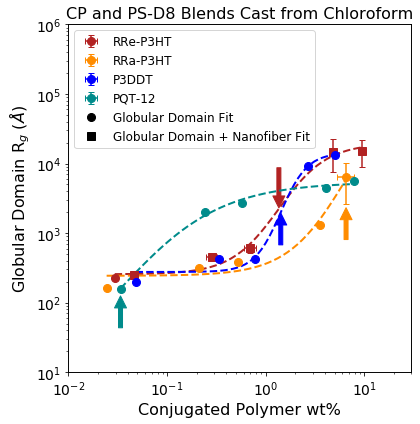

In [92]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# plot_rg_reps(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', ax1, ax2, violin_plot=False)
# plot_rg_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2, violin_plot=False)
# plot_rg_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2, violin_plot=False)
# plot_rg_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2, violin_plot=False)

plot_rg_reps(rre_cf_glob, rre_cf_cyl, 'RRe-P3HT', 'firebrick', ax1, ax2, violin_plot=False)
plot_rg_reps(rra_cf_glob, rra_cf_cyl, 'RRa-P3HT', 'darkorange', ax1, ax2, violin_plot=False)
plot_rg_reps(p3ddt_cf_glob, p3ddt_cf_cyl, 'P3DDT', 'blue', ax1, ax2, violin_plot=False)
plot_rg_reps(pqt_cf_glob, pqt_cf_cyl, 'PQT-12', 'darkcyan', ax1, ax2, violin_plot=False)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'Globular Domain R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Globular Domain Fit', color='black',ms=8)
#ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Globular Domain + Nanofiber Fit', color='black',ms=8)
#ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('CP and PS-D8 Blends Cast from Chloroform',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RRaP3HT_P3DDT_PQT12_CF_rg_reps.png', dpi=300)

-3.525375847244114 2.259869957685868
Chloroform 1.36 [0.30778967 1.77960446 4.33510958 5.54452834]
-2.335592783387191 2.310975386543173
Toluene 0.097 [-2.33559278  0.64172888  9.1120838   0.43994294]
-2.6939802775662547 2.306486984463912
step location not found
Bromobenzene 10.039 [2.30648698 0.744965   7.99295322 5.95842406]


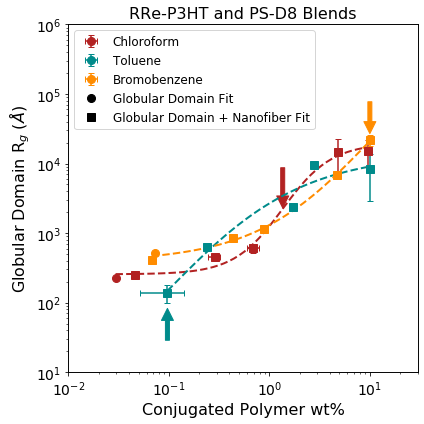

In [97]:

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plot_rg_reps(rre_cf_glob, rre_cf_cyl, 'Chloroform', 'firebrick', ax1, ax2, violin_plot=False)
plot_rg_reps(rre_tol_glob, rre_tol_cyl, 'Toluene',  'darkcyan', ax1, ax2, violin_plot=False)
plot_rg_reps(rre_bb_glob, rre_bb_cyl, 'Bromobenzene',  'darkorange', ax1, ax2, violin_plot=False)
# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'Globular Domain R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Globular Domain Fit', color='black',ms=8)
#ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Globular Domain + Nanofiber Fit', color='black',ms=8)
#ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('RRe-P3HT and PS-D8 Blends',fontsize=16)
plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RReP3HT_all_radius_reps.png', dpi=300)



-3.037707990893476 1.6107108415228488
Chloroform 1.422 [0.35176493 3.2311592  3.9464618  5.62132498]


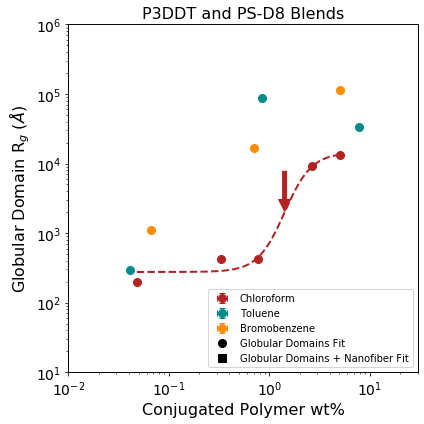

In [98]:

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plot_rg_reps(p3ddt_cf_glob, p3ddt_cf_cyl, 'Chloroform', 'firebrick', ax1, ax2, violin_plot=False)
plot_rg_reps(p3ddt_tol_glob, p3ddt_tol_cyl, 'Toluene',  'darkcyan', ax1, ax2, violin_plot=False, logistic_fit=False)
plot_rg_reps(p3ddt_bb_glob, p3ddt_bb_cyl, 'Bromobenzene',  'darkorange', ax1, ax2, violin_plot=False, logistic_fit=False)
# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'Globular Domain R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Globular Domains Fit', color='black',ms=8)
#ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Globular Domains + Nanofiber Fit', color='black',ms=8)
#ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.legend(fontsize=10,loc='lower right',ncol=1)# ncol=3)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('P3DDT and PS-D8 Blends',fontsize=16)
plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/P3DDT_all_radius_reps.png', dpi=300)



In [26]:
def plot_rad_reps(sphere_keys, ellipsoid_keys, sphcyl_keys, ellcyl_keys, sphere_label, color, ax1, ax2, indiv=True, violin_plot=True):
    
    if indiv is True:
        sphere_keys = [[key] for sublist in sphere_keys for key in sublist]
        ellipsoid_keys = [[key] for sublist in ellipsoid_keys for key in sublist]
        sphcyl_keys = [[key] for sublist in sphcyl_keys for key in sublist]
        ellcyl_keys = [[key] for sublist in ellcyl_keys for key in sublist]
    
    def get_lognormal_pd(med, pd, n, nsigma, n_tot = 20000):
    
        mu = np.log(med)
        sigma = pd

        p = pd*med

        low = med - nsigma*p
        high = med + nsigma*p

        x = np.linspace(low, high, n)
        x = x[np.where(x>0)]
        f = (np.reciprocal(x*sigma))*np.exp((-0.5)*(((np.log(x)-mu)/sigma)**2))
        
        dist = np.random.choice(x,p=f/np.sum(f),size=100000)
    
        return(dist)
    
    alph = 0.4
    widt = 0.6
    
    wtP_all = []
    radius_all = []
    
    '''
    Plotting sphere fits
    '''
    
    wtP = []
    radius_list = []
    wtP_error_list = []
    radius_error_list = []
    
    for sub_key in sphere_keys:
        sub_wtP = []
        sub_radius_list = []
        for key in sub_key:
            sub_wtP.append(actual[key])
            r_sphere = fit_sphere_radius[key][0]
            #r_sphere = rg_sphere(r_sphere)
            sub_radius_list.append(r_sphere)

#         if len(sub_wtP) > 1:
#             #print(sphere_label, sub_wtP, np.average(sub_wtP), np.std(sub_wtP))
#             wtP.append(np.average(sub_wtP))
#             radius_list.append(np.average(sub_radius_list))
#             wtP_error_list.append(np.std(sub_wtP))
#             radius_error_list.append(np.std(sub_radius_list))
#             #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
#         else:
        wtP.append(sub_wtP[0])
        radius_list.append(sub_radius_list[0])
        wtP_error_list.append(0)
        radius_error_list.append(0)
        #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
                
    if len(wtP)>0:
        violin = []
        for pos,rad in zip(wtP, radius_list):
            violin.append(get_lognormal_pd( rad, 0.5, 200, 8))
        if violin_plot is True:
            vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

            for pc in vp['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alph) 
            
    #ax1.errorbar(wtP, radius_list, xerr=wtP_error_list, yerr=radius_error_list, label=sphere_label, color=color, fmt='o', ms=8, zorder=100)
    
    wtP1 = np.array(wtP)
    radius_list1 = np.array(radius_list)
    wtP_error_list1 = np.array(wtP_error_list)
    radius_error_list1 = np.array(radius_error_list)
    
    wtP_all.extend(wtP)
    radius_all.extend(radius_list)
    
    '''
    Plotting ellipsoid fits
    '''
    
    wtP = []
    radius_list = []
    radius_list_polar = []
    wtP_error_list = []
    radius_error_list = []
    
    for sub_key in ellipsoid_keys:
        sub_wtP = []
        sub_radius_list = []
        sub_radius_list_polar = []
        for key in sub_key:
            
            sub_wtP.append(actual[key])
            radius_polar = fit_ellipsoid_polar_radius[key][0]
            radius_equatorial = fit_ellipsoid_equatorial_radius[key][0]
            r_ellipsoid = radius_equatorial
            r_ellipsoid_polar = radius_polar
            sub_radius_list.append(r_ellipsoid)
            sub_radius_list_polar.append(r_ellipsoid_polar)

#         if len(sub_wtP) > 1:
#             wtP.append(np.average(sub_wtP))
#             radius_list.append(np.average(sub_radius_list))
#             wtP_error_list.append(np.std(sub_wtP))
#             radius_error_list.append(np.std(sub_radius_list))
#             #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
#             #print(sphere_label, sub_wtP, np.average(sub_wtP), np.std(sub_wtP))
#         else:
        wtP.append(sub_wtP[0])
        radius_list.append(sub_radius_list[0])
        radius_list_polar.append(sub_radius_list_polar[0])
        wtP_error_list.append(0)
        radius_error_list.append(0)
        #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)

    if len(wtP)>0:
        violin = []
        for pos,rad in zip(wtP, radius_list):
            violin.append(get_lognormal_pd( rad, 0.5, 200, 8))
        if violin_plot is True:
            vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

            for pc in vp['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alph)
                
        violin = []
        for pos,rad in zip(wtP, radius_list_polar):
            violin.append(get_lognormal_pd( rad, 0.5, 200, 8))
        if violin_plot is True:
            vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

            for pc in vp['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alph)
        
    #ax1.errorbar(wtP, radius_list, xerr=wtP_error_list, yerr=radius_error_list, color=color, fmt='^', ms=8, zorder=100)
    
    wtP2 = np.array(wtP)
    radius_list2 = np.array(radius_list)
    radius_list_polar2 = np.array(radius_list_polar)
    wtP_error_list2 = np.array(wtP_error_list)
    radius_error_list2 = np.array(radius_error_list)
    
    wtP_all.extend(wtP)
    radius_all.extend(radius_list)
    
    
    
    
    
    '''
    Plotting sphere+cylinder fits
    '''

    
    wtP = []
    radius_list = []
    wtP_error_list = []
    radius_error_list = []
    
    for sub_key in sphcyl_keys:
        sub_wtP = []
        sub_radius_list = []
        for key in sub_key:
            sub_wtP.append(actual[key])
            r_sphere = fit_sphcyl_sphere_radius[key][0]
            #r_sphere = rg_sphere(r_sphere)
            sub_radius_list.append(r_sphere)

#         if len(sub_wtP) > 1:
#             wtP.append(np.average(sub_wtP))
#             radius_list.append(np.average(sub_radius_list))
#             wtP_error_list.append(np.std(sub_wtP))
#             radius_error_list.append(np.std(sub_radius_list))
#             #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
#             #print(sphere_label, sub_wtP, np.average(sub_wtP), np.std(sub_wtP))
#         else:
        wtP.append(sub_wtP[0])
        radius_list.append(sub_radius_list[0])
        wtP_error_list.append(0)
        radius_error_list.append(0)
        #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
    
    if len(wtP)>0:
        violin = []
        for pos,rad in zip(wtP, radius_list):
            violin.append(get_lognormal_pd( rad, 0.5, 200, 8))
        if violin_plot is True:
            vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

            for pc in vp['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alph)   
    #ax1.errorbar(wtP, radius_list, xerr=wtP_error_list, yerr=radius_error_list, color=color, fmt='s', ms=8, zorder=100)
    
    wtP3 = np.array(wtP)
    radius_list3 = np.array(radius_list)
    wtP_error_list3 = np.array(wtP_error_list)
    radius_error_list3 = np.array(radius_error_list)
    
    wtP_all.extend(wtP)
    radius_all.extend(radius_list)
    
    '''
    Plotting ellipsoid+cylinder fits
    '''
    
    wtP = []
    radius_list = []
    radius_list_polar = []
    wtP_error_list = []
    radius_error_list = []
    
    for sub_key in ellcyl_keys:
        sub_wtP = []
        sub_radius_list = []
        sub_radius_list_polar = []
        for key in sub_key:
            
            sub_wtP.append(actual[key])
            radius_polar = fit_ellcyl_polar_radius[key][0]
            radius_equatorial = fit_ellcyl_equatorial_radius[key][0]
            r_ellipsoid = radius_equatorial
            sub_radius_list.append(r_ellipsoid)
            sub_radius_list_polar.append(radius_polar)

#         if len(sub_wtP) > 1:
#             wtP.append(np.average(sub_wtP))
#             radius_list.append(np.average(sub_radius_list))
#             wtP_error_list.append(np.std(sub_wtP))
#             radius_error_list.append(np.std(sub_radius_list))
#             #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
#             #print(sphere_label, sub_wtP, np.average(sub_wtP), np.std(sub_wtP))
#         else:
        wtP.append(sub_wtP[0])
        radius_list.append(sub_radius_list[0])
        radius_list_polar.append(sub_radius_list_polar[0])
        wtP_error_list.append(0)
        radius_error_list.append(0)
        #print(wtP, radius_list, wtP_error_list, radius_error_list, sphere_label)
    
    if len(wtP)>0:
        violin = []
        for pos,rad in zip(wtP, radius_list):
            violin.append(get_lognormal_pd( rad, 0.5, 200, 8))
        if violin_plot is True:
            vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

            for pc in vp['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alph)
                
        violin = []
        for pos,rad in zip(wtP, radius_list_polar):
            violin.append(get_lognormal_pd( rad, 0.5, 200, 8))
        if violin_plot is True:
            vp = ax2.violinplot(violin, positions=np.log(wtP), widths=widt, showextrema=False)

            for pc in vp['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
                pc.set_alpha(alph)
    
    #ax1.errorbar(wtP, radius_list, xerr=wtP_error_list, yerr=radius_error_list, color=color, fmt='D', ms=8, zorder=100)
    
    wtP4 = np.array(wtP)
    radius_list4 = np.array(radius_list)
    radius_list_polar4 = np.array(radius_list_polar)
    wtP_error_list4 = np.array(wtP_error_list)
    radius_error_list4 = np.array(radius_error_list)
    
    wtP_all.extend(wtP)
    radius_all.extend(radius_list)
    
    
    
    ax1.errorbar(wtP1, radius_list1, xerr=wtP_error_list1, yerr=radius_error_list1, label=sphere_label, color=color, fmt='o', ms=8, zorder=100)
    ax1.errorbar(wtP2, radius_list2, xerr=wtP_error_list2, yerr=radius_error_list2, color=color, fmt='^', ms=8, zorder=100)
    ax1.errorbar(wtP2, radius_list_polar2, xerr=wtP_error_list2, yerr=radius_error_list2, color=color, fmt='^', ms=8, zorder=100)
    for wt, rad1, rad2 in zip(wtP2, radius_list2, radius_list_polar2):
        ax1.plot([wt,wt],[rad1,rad2],color=color)
    
    
    ax1.errorbar(wtP3, radius_list3, xerr=wtP_error_list3, yerr=radius_error_list3, color=color, fmt='s', ms=8, zorder=100)
    ax1.errorbar(wtP4, radius_list4, xerr=wtP_error_list4, yerr=radius_error_list4, color=color, fmt='D', ms=8, zorder=100)
    ax1.errorbar(wtP4, radius_list_polar4, xerr=wtP_error_list4, yerr=radius_error_list4, color=color, fmt='D', ms=8, zorder=100)
    for wt, rad1, rad2 in zip(wtP4, radius_list4, radius_list_polar4):
        ax1.plot([wt,wt],[rad1,rad2],color=color)
    


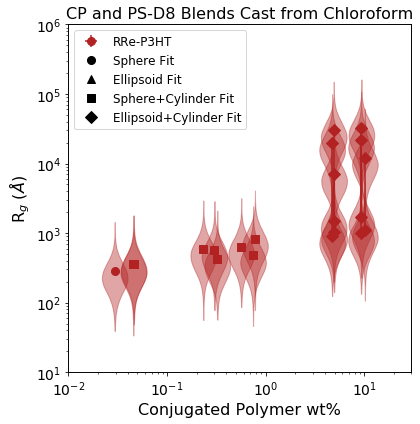

In [27]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plot_rad_reps(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', ax1, ax2)
#plot_rad_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2)
#plot_rad_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2)
#plot_rad_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('CP and PS-D8 Blends Cast from Chloroform',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RReP3HT_CF_radius.png', dpi=300)

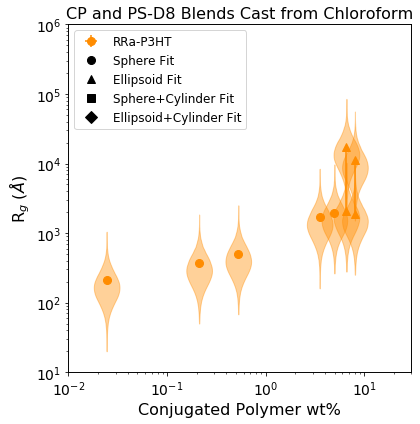

In [28]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

#plot_rad_reps(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', ax1, ax2)
plot_rad_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2)
#plot_rad_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2)
#plot_rad_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('CP and PS-D8 Blends Cast from Chloroform',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RRaP3HT_CF_radius.png', dpi=300)

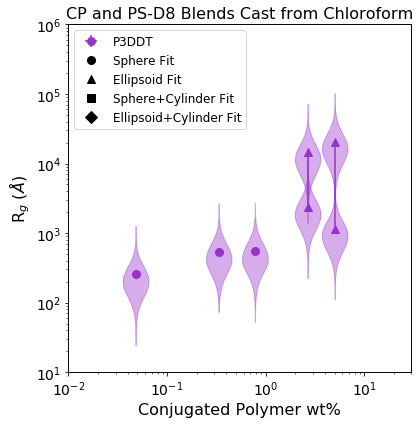

In [29]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

#plot_rad_reps(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', ax1, ax2)
#plot_rad_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2)
plot_rad_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2)
#plot_rad_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('CP and PS-D8 Blends Cast from Chloroform',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/P3DDT_CF_radius.png', dpi=300)

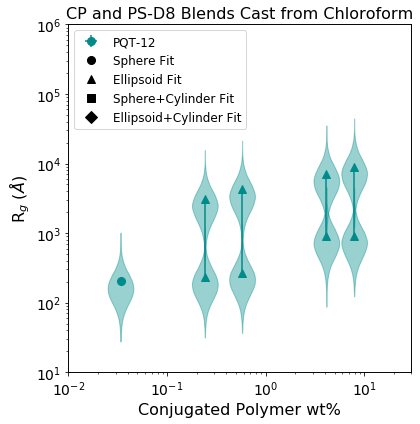

In [30]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

#plot_rad_reps(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', ax1, ax2)
#plot_rad_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2)
#plot_rad_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2)
plot_rad_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('CP and PS-D8 Blends Cast from Chloroform',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/PQT12_CF_radius.png', dpi=300)

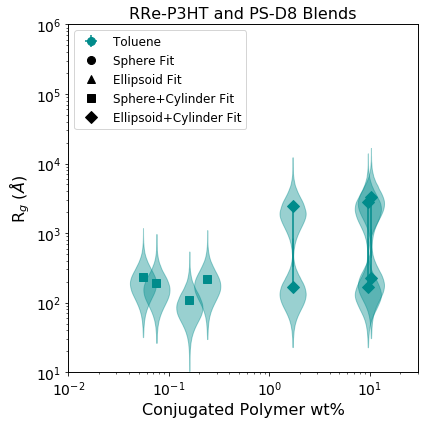

In [31]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plot_rad_reps(rre_tol_spheres, rre_tol_ellipsoids, rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan', ax1, ax2)
#plot_rad_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2)
#plot_rad_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2)
#plot_rad_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('RRe-P3HT and PS-D8 Blends',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RReP3HT_Tol_radius.png', dpi=300)

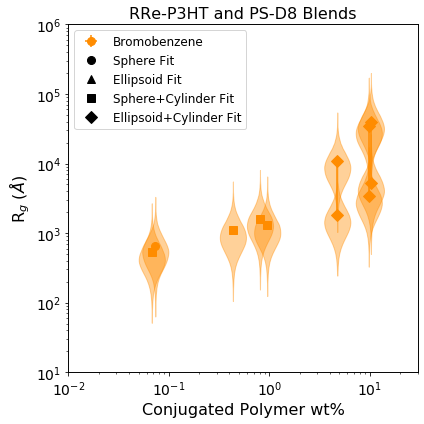

In [32]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plot_rad_reps(rre_bb_spheres, rre_bb_ellipsoids, rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange', ax1, ax2)
#plot_rad_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2)
#plot_rad_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2)
#plot_rad_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('RRe-P3HT and PS-D8 Blends',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RReP3HT_BB_radius.png', dpi=300)

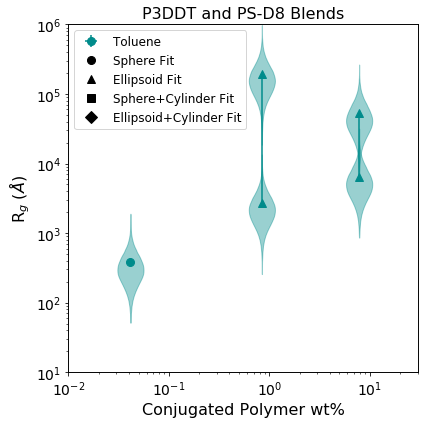

In [33]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plot_rad_reps(p3ddt_tol_spheres, p3ddt_tol_ellipsoids, p3ddt_tol_sphcyl, p3ddt_tol_ellcyl, 'Toluene', 'darkcyan', ax1, ax2)
#plot_rad_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2)
#plot_rad_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2)
#plot_rad_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('P3DDT and PS-D8 Blends',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/P3DDT_Tol_radius.png', dpi=300)

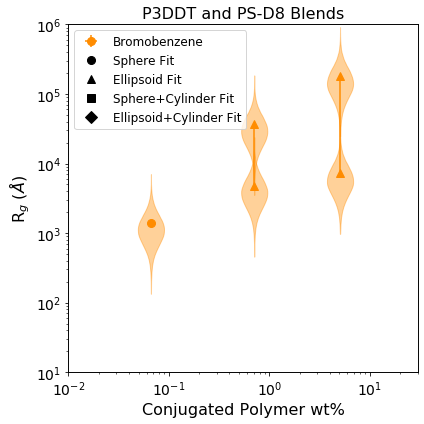

In [34]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plot_rad_reps(p3ddt_bb_spheres, p3ddt_bb_ellipsoids, p3ddt_bb_sphcyl, p3ddt_bb_ellcyl, 'Bromobenzene', 'darkorange', ax1, ax2)
#plot_rad_reps(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', ax1, ax2)
#plot_rad_reps(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', ax1, ax2)
#plot_rad_reps(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', ax1, ax2)

# plt.xscale('log')
# plt.xlim(0.001,100)
# plt.xlabel('Conjugated Polymer wt%', fontsize=16)
#plt.xticks(fontsize=14)

ax1.set_xscale('log')
ax1.set_xlim(0.01,30)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=16)

ax2.set_xlim(np.log(0.01),np.log(30))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(1e1,1e6)
ax1.set_ylabel(r'R$_g$ ($\AA$)', fontsize=16) 

ax1.tick_params(axis='both', labelsize=14)


ax1.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
ax1.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)
#plt.errorbar([0],[0],fmt='-',label='Logistic Function Trendline', color='black',ms=8)

ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('P3DDT and PS-D8 Blends',fontsize=16)

ax1.legend(fontsize=12,loc='upper left',ncol=1)# ncol=3)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/P3DDT_BB_radius.png', dpi=300)

In [99]:
def plot_scale(sphere_list, ellipsoid_list, sphcyl_list, ellcyl_list, label, color):
    
    sphere_list = [key for sublist in sphere_list for key in sublist]
    ellipsoid_list = [key for sublist in ellipsoid_list for key in sublist]
    sphcyl_list = [key for sublist in sphcyl_list for key in sublist]
    ellcyl_list = [key for sublist in ellcyl_list for key in sublist]
    
    # sphere
    wtP = []
    radius_list = []
    #radius_error = []

    for key in sphere_list:
        wtP.append(actual_vol[key])
        radius_list.append(fit_sphere_scale[key][0]*100)
        #radius_error.append(fit_sphere_scale[key][1][0]*100)
        #radius_error.append(fit_sphere_scale[key][1][1]*100)
     
    #radius_error = np.array(radius_error).reshape(-1,2).T
    radius_list = np.array(radius_list)
    #radius_error_corr = np.absolute(radius_error - radius_list)
    
    #plt.errorbar(wtP, radius_list, yerr=radius_error_corr, capsize=7, c=color, label=label, fmt='o', ms=7, zorder=1)
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=label, fmt='o', ms=7, zorder=1)
    
    # ellipsoid
    wtP = []
    radius_list = []
    #radius_error = []

    for key in ellipsoid_list:
        wtP.append(actual_vol[key])
        radius_list.append(fit_ellipsoid_scale[key][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][1]*100)

    #radius_error = np.array(radius_error).reshape(-1,2).T
    radius_list = np.array(radius_list)
    #radius_error_corr = np.absolute(radius_error - radius_list)
    
    #plt.errorbar(wtP, radius_list, yerr=radius_error_corr, capsize=7, c=color, label=None, fmt='^', ms=7, zorder=1)
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='^', ms=7, zorder=1)

    # sphere+cylinder
    wtP = []
    radius_list = []
    #radius_error = []

    for key in sphcyl_list:
        wtP.append(actual_vol[key])
        radius_list.append(fit_sphcyl_cp_scale[key][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][1]*100)

    #radius_error = np.array(radius_error).reshape(-1,2).T
    radius_list = np.array(radius_list)
    #radius_error_corr = np.absolute(radius_error - radius_list)
    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='s', ms=7, zorder=1)

    
    # ellipsoid+cylinder
    wtP = []
    radius_list = []
    #radius_error = []

    for key in ellcyl_list:
        wtP.append(actual_vol[key])
        radius_list.append(fit_ellcyl_cp_scale[key][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][1]*100)

    #radius_error = np.array(radius_error).reshape(-1,2).T
    radius_list = np.array(radius_list)
    #radius_error_corr = np.absolute(radius_error - radius_list)
    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='D', ms=7, zorder=1)



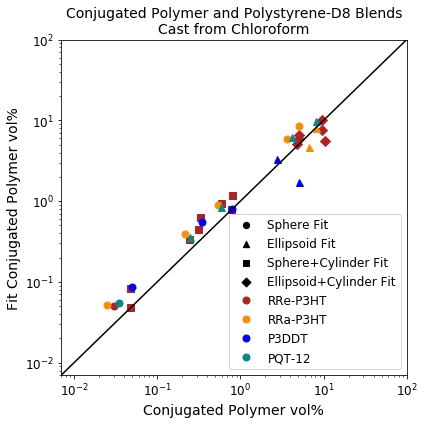

In [100]:
plt.figure(figsize=(6,6))


plot_scale(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick')
plot_scale(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange')
plot_scale(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'blue')
plot_scale(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan')

plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='lower right')

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/CF_scales.png', dpi=300)

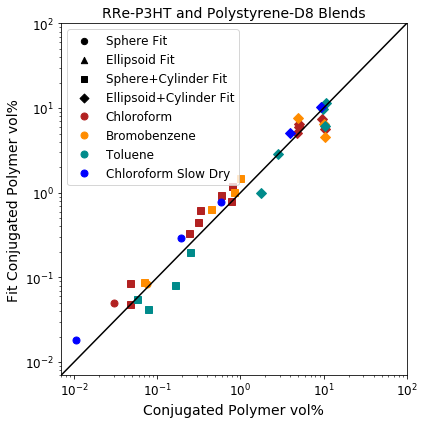

In [101]:
plt.figure(figsize=(6,6))


plot_scale(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick')
plot_scale(rre_bb_spheres, rre_bb_ellipsoids, rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange')
plot_scale(rre_tol_spheres, rre_tol_ellipsoids, rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan')
plot_scale(rre_cf_slow_spheres, rre_cf_slow_ellipsoids, rre_cf_slow_sphcyl, rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'blue')


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RReP3HT_scales.png', dpi=300)

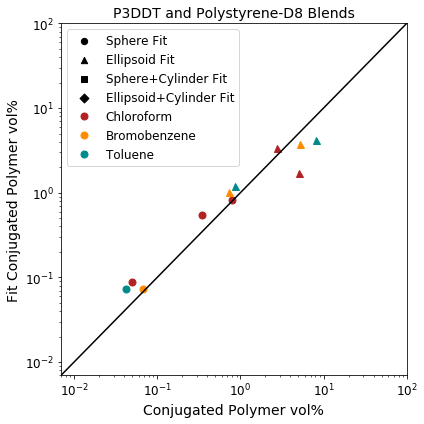

In [102]:
plt.figure(figsize=(6,6))


plot_scale(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'Chloroform', 'firebrick')
plot_scale(p3ddt_bb_spheres, p3ddt_bb_ellipsoids, p3ddt_bb_sphcyl, p3ddt_bb_ellcyl, 'Bromobenzene', 'darkorange')
plot_scale(p3ddt_tol_spheres, p3ddt_tol_ellipsoids, p3ddt_tol_sphcyl, p3ddt_tol_ellcyl, 'Toluene', 'darkcyan')


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('P3DDT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/P3DDT_scales.png', dpi=300)

### Nanofiber Concentration

In [105]:
def plot_nf_concentration(sphcyl_list, ellcyl_list, label, color, fit_scale=False):
    
    sphcyl_list = [key for sublist in sphcyl_list for key in sublist]
    ellcyl_list = [key for sublist in ellcyl_list for key in sublist]
    
    def vol2wtP(v_cp):
        den_cp = 1.1
        den_ps = 1.13
        
        m_cp = v_cp*den_cp
        m_ps = (1-v_cp)*den_ps
        
        x_cp = m_cp/(m_cp+m_ps)
        return(x_cp)
    
    # sphere+cylinder
    wtP = []
    radius_list = []

    for key in sphcyl_list:
        if fit_scale is True:
            wtP.append(vol2wtP(fit_sphcyl_cp_scale[key][0])*100)
            radius_list.append(vol2wtP(fit_sphcyl_cp_scale[key][0])*100*(1-fit_sphcyl_scale_ratio[key][0]))
        else:
            wtP.append(actual[key])
            radius_list.append(actual[key]*(1-fit_sphcyl_scale_ratio[key][0]))
        
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=label, fmt='s', ms=7, zorder=1)

    
    # ellipsoid+cylinder
    wtP = []
    radius_list = []

    for key in ellcyl_list:
        if fit_scale is True:
            wtP.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100)
            radius_list.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100*(1-fit_ellcyl_scale_ratio[key][0]))
        else:
            wtP.append(actual[key])
            radius_list.append(actual[key]*(1-fit_ellcyl_scale_ratio[key][0]))
       
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='D', ms=7, zorder=1)



In [110]:
def plot_nf_concentration_reps(cyl_list, label, color, fit_scale=False):

    
    def vol2wtP(v_cp):
        den_cp = 1.1
        den_ps = 1.13
        
        m_cp = v_cp*den_cp
        m_ps = (1-v_cp)*den_ps
        
        x_cp = m_cp/(m_cp+m_ps)
        return(x_cp)
    
    # sphere+cylinder

    wtP_all = []
    radius_all = []
    wtP_error_all = []
    radius_error_all = []
    
    for sub_key in cyl_list:
        wtP = []
        radius_list = []
        for key in sub_key:
            if key in final_keys_sphere_cylinders:
                if fit_scale is True:
                    wtP.append(vol2wtP(fit_sphcyl_cp_scale[key][0])*100)
                    radius_list.append(vol2wtP(fit_sphcyl_cp_scale[key][0])*100*(1-fit_sphcyl_scale_ratio[key][0]))
                else:
                    wtP.append(actual[key])
                    radius_list.append(actual[key]*(1-fit_sphcyl_scale_ratio[key][0]))
                    
            elif key in final_keys_ellipsoid_cylinders:
                if fit_scale is True:
                    wtP.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100)
                    radius_list.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100*(1-fit_ellcyl_scale_ratio[key][0]))
                else:
                    wtP.append(actual[key])
                    radius_list.append(actual[key]*(1-fit_ellcyl_scale_ratio[key][0]))
        if len(wtP)>1:
            wtP_all.append(np.average(wtP))
            wtP_error_all.append(np.std(wtP))
            radius_all.append(np.average(radius_list))
            radius_error_all.append(np.std(radius_list))
        else:
            wtP_all.append(wtP[0])
            wtP_error_all.append(0)
            radius_all.append(radius_list[0])
            radius_error_all.append(0)
            
            

    #radius_list = np.array(radius_list)    
    plt.errorbar(wtP_all, radius_all, xerr=wtP_error_all, yerr=radius_error_all, c=color, label=label, fmt='o', ms=7, zorder=1, capsize=3)

    
#     # ellipsoid+cylinder
#     wtP_all = []
#     radius_all = []
#     wtP_error_all = []
#     radius_error_all = []
    
#     for sub_key in ellcyl_list:
#         wtP = []
#         radius_list = []
#         for key in sub_key:
#             if fit_scale is True:
#                 wtP.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100)
#                 radius_list.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100*(1-fit_ellcyl_scale_ratio[key][0]))
#             else:
#                 wtP.append(actual[key])
#                 radius_list.append(actual[key]*(1-fit_ellcyl_scale_ratio[key][0]))
#         if len(wtP)>1:
#             wtP_all.append(np.average(wtP))
#             wtP_error_all.append(np.std(wtP))
#             radius_all.append(np.average(radius_list))
#             radius_error_all.append(np.std(radius_list))
#         else:
#             wtP_all.append(wtP[0])
#             wtP_error_all.append(0)
#             radius_all.append(radius_list[0])
#             radius_error_all.append(0)
            
#     #radius_list = np.array(radius_list)    
#     plt.errorbar(wtP_all, radius_all, xerr=wtP_error_all, yerr=radius_error_all, c=color, label=None, fmt='D', ms=7, zorder=1)



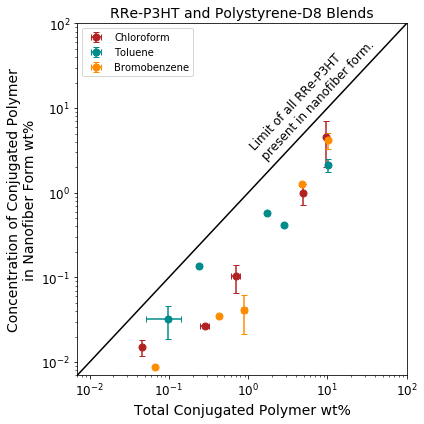

In [111]:
plt.figure(figsize=(6,6))


# plot_nf_concentration_reps(rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick', fit_scale=False)
# plot_nf_concentration_reps(rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan', fit_scale=False)
# plot_nf_concentration_reps(rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange', fit_scale=False)
#plot_nf_concentration_reps(rre_cf_slow_sphcyl, rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'darkorchid', fit_scale=False)
plot_nf_concentration_reps(rre_cf_cyl, 'Chloroform', 'firebrick', fit_scale=False)
plot_nf_concentration_reps(rre_tol_cyl, 'Toluene', 'darkcyan', fit_scale=False)
plot_nf_concentration_reps(rre_bb_cyl, 'Bromobenzene', 'darkorange', fit_scale=False)


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
#plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
#plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Total Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Concentration of Conjugated Polymer\nin Nanofiber Form wt%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=10,loc='upper left')

plt.annotate('Limit of all RRe-P3HT\npresent in nanofiber form.',[1,2.5],xycoords='data',rotation=47,fontsize=12)

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RReP3HT_NFconc_UVVisScales_reps.png', dpi=300)


### Plotting Nanofiber Size

In [112]:
def plot_nf_rad(sphcyl_list, ellcyl_list, label, color):
    
    
    def vol2wtP(v_cp):
        den_cp = 1.1
        den_ps = 1.13
        
        m_cp = v_cp*den_cp
        m_ps = (1-v_cp)*den_ps
        
        x_cp = m_cp/(m_cp+m_ps)
        return(x_cp)
    
    # sphere+cylinder
    wtP = []
    radius_list = []

    for key in sphcyl_list:
        wtP.append(actual[key])
        radius_list.append(fit_sphcyl_cylinder_radius[key][0])
          
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=label, fmt='s', ms=7, zorder=1)

    
    # ellipsoid+cylinder
    wtP = []
    radius_list = []

    for key in ellcyl_list:
        wtP.append(actual[key])
        radius_list.append(fit_ellcyl_cylinder_radius[key][0])
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='D', ms=7, zorder=1)
    
  

In [114]:
def plot_nf_rad_reps(cyl_list, label, color, polynomial_n,ax1,ax2):
    
    def get_lognormal_pd(med, pd, n, nsigma, n_tot = 20000):
    
        mu = np.log(med)
        sigma = pd

        p = pd*med

        low = med - nsigma*p
        high = med + nsigma*p

        x = np.linspace(low, high, n)
        x = x[np.where(x>0)]
        f = (np.reciprocal(x*sigma))*np.exp((-0.5)*(((np.log(x)-mu)/sigma)**2))
        
        dist = np.random.choice(x,p=f/np.sum(f),size=100000)
    
        return(dist)
    
    alph = 0.4
    widt = 0.5
    
    wtP_fit = []
    radius_fit = []
    
    def vol2wtP(v_cp):
        den_cp = 1.1
        den_ps = 1.13
        
        m_cp = v_cp*den_cp
        m_ps = (1-v_cp)*den_ps
        
        x_cp = m_cp/(m_cp+m_ps)
        return(x_cp)
    
    # sphere+cylinder
    wtP_all = []
    radius_all = []
    wtP_error_all = []
    radius_error_all = []
    
    for sub_key in cyl_list:
    
        wtP = []
        radius_list = []
        
        for key in sub_key:

            if key in final_keys_sphere_cylinders:
                wtP.append(actual[key])
                radius_list.append(fit_sphcyl_cylinder_radius[key][0])
            elif key in final_keys_ellipsoid_cylinders:
                wtP.append(actual[key])
                radius_list.append(fit_ellcyl_cylinder_radius[key][0])
                    
        if len(wtP)>1:
            wtP_all.append(np.average(wtP))
            wtP_error_all.append(np.std(wtP))
            radius_all.append(np.average(radius_list))
            radius_error_all.append(np.std(radius_list))
        else:
            wtP_all.append(wtP[0])
            wtP_error_all.append(0)
            radius_all.append(radius_list[0])
            radius_error_all.append(0)
            
    wtP_fit.extend(wtP_all)
    radius_fit.extend(radius_all)
    
    if len(wtP_all)>0:
        violin = []
        for pos,rad in zip(wtP_all, radius_all):
            violin.append(get_lognormal_pd(rad, 0.2, 200, 8))
        vp = ax2.violinplot(violin, positions=np.log(wtP_all), widths=widt, showextrema=False)

        for pc in vp['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor(color)
            pc.set_alpha(alph)

    ax1.errorbar(wtP_all, radius_all, xerr=wtP_error_all, yerr=radius_error_all,  c=color, label=label, fmt='o', ms=7, zorder=1, capsize=3)

    
#     # ellipsoid+cylinder
#     wtP_all = []
#     radius_all = []
#     wtP_error_all = []
#     radius_error_all = []
    
#     for sub_key in ellcyl_list:
    
#         wtP = []
#         radius_list = []

#         for key in sub_key:
#             wtP.append(actual[key])
#             radius_list.append(fit_ellcyl_cylinder_radius[key][0])
            
#         if len(wtP)>1:
#             wtP_all.append(np.average(wtP))
#             wtP_error_all.append(np.std(wtP))
#             radius_all.append(np.average(radius_list))
#             radius_error_all.append(np.std(radius_list))
#         else:
#             wtP_all.append(wtP[0])
#             wtP_error_all.append(0)
#             radius_all.append(radius_list[0])
#             radius_error_all.append(0)
            

#     wtP_fit.extend(wtP_all)
#     radius_fit.extend(radius_all)
    
#     if len(wtP_all)>0:
#         violin = []
#         for pos,rad in zip(wtP_all, radius_all):
#             violin.append(get_lognormal_pd(rad, 0.2, 200, 8))
#         vp = ax2.violinplot(violin, positions=np.log(wtP_all), widths=widt, showextrema=False)

#         for pc in vp['bodies']:
#             pc.set_facecolor(color)
#             pc.set_edgecolor(color)
#             pc.set_alpha(alph)
            
#     ax1.errorbar(wtP_all, radius_all, xerr=wtP_error_all, yerr=radius_error_all, c=color, label=None, fmt='D', ms=7, zorder=1)
    
  

    '''
    Fit a polynomial 
    '''
    
    if polynomial_n > 0:
        fit_params = np.polyfit(np.log(wtP_fit), np.log(radius_fit), polynomial_n)
        fit_function = np.poly1d(fit_params)
        x_fit = np.linspace(min(np.log(wtP_fit)), max(np.log(wtP_fit)), 100)
        y_fit = fit_function(x_fit)
        ax1.plot(np.exp(x_fit), np.exp(y_fit), '--', c=color, label=None)


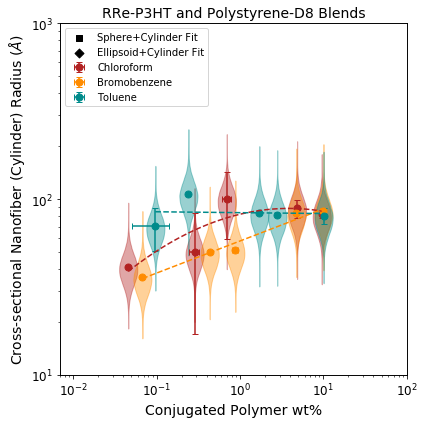

In [115]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plot_nf_rad_reps(rre_cf_cyl, 'Chloroform', 'firebrick',2, ax1, ax2)
#plot_nf_rad_reps(rre_cf_slow_sphcyl,rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'darkorchid',0, ax1, ax2)
plot_nf_rad_reps(rre_bb_cyl, 'Bromobenzene', 'darkorange',1, ax1, ax2)
plot_nf_rad_reps(rre_tol_cyl, 'Toluene', 'darkcyan',1, ax1, ax2)



#plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
ax1.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
ax1.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')


ax1.set_xscale('log')
ax1.set_xlim(0.007,100)
ax1.set_xlabel('Conjugated Polymer wt%', fontsize=14)

#ax2.set_xscale('log')
ax2.set_xlim(np.log(0.007),np.log(100))
ax2.set_xticks([])

ax1.set_yscale('log')
ax1.set_ylim(10,1000)
ax1.set_ylabel(r'Cross-sectional Nanofiber (Cylinder) Radius ($\AA$)', fontsize=14) 

ax1.tick_params(axis='both', labelsize=12)


ax1.set_zorder(100)
ax2.set_zorder(1)
ax1.set_facecolor("none")

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

ax1.legend(fontsize=10,loc='upper left',ncol=1)

plt.tick_params(axis='y', which='minor')

plt.tight_layout()
plt.savefig('../../data/sans/Sample_Fitting/fitting_figures/radius_fiber_plots/RReP3HT_NFRad_reps.png', dpi=300)